<a href="https://colab.research.google.com/github/Arthur-barretto/banking_nlp/blob/main/Notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import json
!pip install pdfplumber
import pdfplumber
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.8 MB/s eta 0:00:00


In [ ]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# As funções abaixo foram adaptadas de: https://github.com/jsvine/pdfplumber/issues/356#issuecomment-1471361607

# Retorna se um objeto não está contido em outro
# Por exemplo: se um texto está contido em uma tabela ou figura
def not_within_bboxes(obj,bboxes):

    def obj_in_bbox(_bbox):
        v_mid = (obj["top"] + obj["bottom"]) / 2
        h_mid = (obj["x0"] + obj["x1"]) / 21
        x0, top, x1, bottom = _bbox
        return (h_mid >= x0) and (h_mid < x1) and (v_mid >= top) and (v_mid < bottom)

    return not any(obj_in_bbox(__bbox) for __bbox in bboxes)

def curves_to_edges(cs):
    edges = []
    for c in cs:
        edges += pdfplumber.utils.rect_to_edges(c)
    return edges

# Extrai o texto de um arquivo PDF que não está dentro de tabelas ou figuras
def raw_text_extract(pdf_file, include_tables=False, include_images=False, show_page_number=False):
    page_data = []
    with pdfplumber.open(pdf_file) as pdf:
        for page in pdf.pages:
            #page = pdf.pages[0]

            if show_page_number:
                print(f"Pagina: {page.page_number}")

            #print(page.extract_text())
            bboxes = []
            # identificando as tabelas
            if not include_tables:
                bboxes = [
                    table.bbox
                    for table in page.find_tables(
                    table_settings={
                        "vertical_strategy": "lines",
                        "horizontal_strategy": "lines",
                        "explicit_vertical_lines": curves_to_edges(page.curves) + page.edges,
                        "explicit_horizontal_lines": curves_to_edges(page.curves) + page.edges,
                    }
                    )
                ]
            #print(bboxes)

            # identificando as imagens
            if not include_images:
                for image in page.images:
                    image_bbox = (image['x0'], image['top'], image['x1'], image['bottom'])
                    bboxes.append(image_bbox)
                    #print("img: ",image_bbox)

            # Filtrando os textos que estão fora das caixas das tabelas e das figuras
            page = page.filter(lambda obj: not_within_bboxes(obj, bboxes))

            # a arquivo bbdc-2015-3T-Transcrição da Teleconferência 3T15.pdf gera caracteres duplicados. Esse método resolve o problema.
            # ref: https://github.com/jsvine/pdfplumber/issues/71
            text = page.dedupe_chars().extract_text()


            ##### removendo cabeçalho: bbdc, bbas, prbc -> "Transc... ano": Pode ter ou não "Transcrição da"; Pode ter 3 ou 4 linhas

            # Transcrição da Teleconferência
            # Resultados do 4T09
            # Banco do Brasil (BBAS3 BZ) <- esta linha pode nao aparecer no BBDC
            # 26 de fevereiro de 2010

            # prbc-2013-2T13
            # Teleconferência do Paraná Banco
            # Resultados do 2° trimestre de 2013
            # 14 de junho de 2013 – 11h00 (horário de Brasília)
            text = re.sub(r"(Transcrição da )?Teleconferência(.*)?((?:\n|\r\n?)(.*))?((?:\n|\r\n?)(.*))?(?:\n|\r\n?)(.*)[0-9]{4}( – [0-9]{2}h(.*))?", '', text).strip()

            ##### Removendo cabeçalhos do ITUB
            # Itaú Unibanco
            # Resultados do Terceiro trimestre de 2018
            # 30 de outubro de 2018
            text = re.sub(r"Itaú Unibanco(.*)?((?:\n|\r\n?)(.*))?((?:\n|\r\n?)(.*))?(?:\n|\r\n?)(.*)[0-9]{4}", '', text).strip()

            ##### Removendo cabeçalhos do BBAS
            # - Palavra "#Pública" (3T19 a 3T22) e #interna (1T21 a 1T22)
            text = re.sub(f"#Pública", '', text).strip()

            # - Palavra "#interna" (1T21 a 1T22)
            text = re.sub(f"#interna", '', text).strip()


            # bbas-2006-4T06-Transcrição
            # Local Conference Call
            # Banco do Brasil Nac. – (29314)
            # Resultados do Exercício de 2006
            # 28 de Fevereiro de 2007 – 11:00h - horário local
            text = re.sub(r"Local Conference Call(?:\n|\r\n?)(.*)?((?:\n|\r\n?)(.*))?(?:\n|\r\n?)(.*)", '', text).strip()

            # bbas-2009-4T09-Transcrição.pdf
            # O padrão é este. As linhas iniciais são removidas na regra anterior, mas fica a linha da data, que é removida aqui
            # Transcrição da Teleconferência
            # Resultados do 4T09
            # Banco do Brasil (BBAS3 BZ)
            # 26 de fevereiro de 2010
            text = re.sub(r"^[0-9]{2}(.*)[0-9]{4}", '', text).strip()

            # Relação com Investidores
            # Transcrição 1T21
            # BANCO DO BRASIL
            # TELECONFERÊNCIA
            # DE RESULTADOS
            # 1T2021
            text = re.sub(r"Relação com Investidores(?:\n|\r\n?)(.*)?((?:\n|\r\n?)(.*))?((?:\n|\r\n?)(.*))?(?:\n|\r\n?)(.*)?(?:\n|\r\n?)(.*)", '', text).strip()

            # bbas-2020-3T20-Transcrição Teleconferência 3T20.pdf
            # BANCO DO BRASIL
            # TELECONFERÊNCIA
            # DE RESULTADOS
            # 3T2020
            # 06/11/2020
            text = re.sub(r"BANCO DO BRASIL(?:\n|\r\n?)(.*)?((?:\n|\r\n?)(.*))?((?:\n|\r\n?)(.*))?(?:\n|\r\n?)(.*)", '', text).strip()


            # removendo cabeçalho: abcb -> "Banco ABC Brasil | Relações com Investidores Transcrição da"
            text = re.sub(r"Banco ABC Brasil \| (.*)((?:\n|\r\n?))", '', text).strip()


            # removendo o número da página que veio junto do texto
            text = re.sub(f"\\n{page.page_number}$", '', text)

            text = re.sub(f'- {page.page_number} -', '', text)


            # removendo o número da página que veio junto do texto: bbdc -> "(cid:1) <pagina>"
            text = re.sub(f"\(cid:1\) {page.page_number}$", '', text).strip()

            # removendo o número da página que veio junto do texto: prbc -> "Página <pagina>"
            text = re.sub(f"Página {page.page_number}$", '', text).strip()

            # removendo o número da página que veio junto do texto: itub -> "1/12"
            text = re.sub(f'{page.page_number}/{len(pdf.pages)}$', '', text).strip()

            # removendo o número da página que veio junto do texto: itub -> "Teleconferência 4T21 2"
            text = re.sub(r'Teleconferência \dT\d{2} \d+$', '', text).strip()

            # removendo o número da página que veio junto do texto:
            # No abcp-2009-3T09, todas as páginas estão com número "9" e
            # no abcp-2009-3T09, todas as páginas estão com número 7
            head, tail = os.path.split(pdf_file)
            if (tail.startswith('abcb-2009')):
                if (tail.startswith('abcb-2009-3T09')):
                    text = re.sub(r'((?:\n|\r\n?))9$', '', text).strip()
                elif (tail.startswith('abcb-2009-4T09')):
                    text = re.sub(r'((?:\n|\r\n?))7$', '', text).strip()

            page_data.append(text)

    return page_data

In [ ]:
def raw_text_extract(pdf_file, include_tables=False, include_images=False, show_page_number=False):
    page_data = []
    raw_text = []
    with pdfplumber.open(pdf_file) as pdf:
        for page in pdf.pages:

            if show_page_number:
                print(f"Pagina: {page.page_number}")

            bboxes = []
            if not include_tables:
                bboxes = [
                    table.bbox
                    for table in page.find_tables(
                        table_settings={
                            "vertical_strategy": "lines",
                            "horizontal_strategy": "lines",
                            "explicit_vertical_lines": curves_to_edges(page.curves) + page.edges,
                            "explicit_horizontal_lines": curves_to_edges(page.curves) + page.edges,
                        }
                    )
                ]

            if not include_images:
                for image in page.images:
                    image_bbox = (image['x0'], image['top'], image['x1'], image['bottom'])
                    bboxes.append(image_bbox)

            # Filter out text within tables or images
            page = page.filter(lambda obj: not_within_bboxes(obj, bboxes))
            text = page.dedupe_chars().extract_text()

            # Preprocess text to clean headers and footers
            text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)

            page_data.append(text)

    return page_data

In [ ]:
def get_sentences(text):
    sentences = sent_tokenize(text, language='portuguese')
    sentences = [s for s in sentences if len(s.strip()) > 2]
    return sentences

def get_tokens(text):
    tokens = word_tokenize(text, language='portuguese')

    return tokens

def get_words(text):
    tokens = get_tokens(text)

    words = [w for w in tokens if w not in string.punctuation]

    return words

In [ ]:
def save_text(filename, sentences):
    with open(filename, 'w') as f:
        for row in sentences:
            if row != '':
                f.write(row+'\n')

In [ ]:
def generate_stats(text):
    stats = {}
    tokens = get_tokens(text)
    num_tokens = len(tokens)

    stats["tokens"] = num_tokens

    return stats

# Calculate Stats

In [ ]:
transcript_folder = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Transcripts/'
transcript_text_folder = "/content/drive/MyDrive/Portfolio Projects/Mestrado/transcricoes_processadas/"

if not os.path.exists(transcript_text_folder):
    os.mkdir(transcript_text_folder)

global_stats = pd.DataFrame()

#Recupera os arquivos que estão na pasta
files = os.listdir(transcript_folder)
files = files#[0:2]

num_files = len(files)
for i, file in enumerate(files):
    path_transcription = transcript_folder + file

    file_name_parts = file.split("-")
    ticker          = file_name_parts[0].strip()
    trimestre       = file_name_parts[2].strip()

    path_folder_ticker = os.path.join(transcript_text_folder, ticker)

    print(path_folder_ticker, ticker, trimestre)
    print('path_transcription', path_transcription)
    if not os.path.exists(path_folder_ticker):
        os.mkdir(path_folder_ticker)

    print('is_file',os.path.isfile(path_transcription))
    if os.path.isfile(path_transcription):
      print(f"Processando arquivo {i+1} de {num_files}")

      print("*** Extraindo texto do PDF: "+ file)
      path_transcription = transcript_folder + file
      if ticker in ['bbas', 'bbdc']:
          page_data = raw_text_extract(path_transcription)
      else:
          page_data = raw_text_extract(path_transcription, include_tables=True, include_images=False)

      #print(page_data)

      print("*** Limpando o texto")
      text = " ".join(page_data)
      text = clean(text)
      #print(text)

      print("*** Gerando sentenças")
      sentences = get_sentences(text)
      num_sentences = len(sentences)
      num_unique_words = len(set(text.split()))
      sentences = ['ticker;ano;trimestre;sentenca']+[f'{ticker};{file_name_parts[1]};{trimestre};"{s}"' for s in sentences]


      #[ print(s) for s in sentences ]

      print("*** Gerando estatísticas")

      stats = {}
      stats['origem']    = ticker
      stats['trimestre'] = trimestre
      stats['sentencas'] = num_sentences
      stats['num_unique_words'] = num_unique_words

      # concatenando os dois dicts
      stats = {**stats, **generate_stats(text)}

      print("*** Salvando arquivo com a sentenças")
      save_text(f"{path_folder_ticker}/{ticker}-{file_name_parts[1]+'-'+trimestre}.csv", sentences)

      global_stats = pd.concat([global_stats, pd.DataFrame.from_dict([stats])])

In [ ]:
global_stats.head()

# EDA

In [ ]:
sns.set_style('whitegrid')

In [ ]:
df_stats = pd.read_csv('/content/drive/MyDrive/Portfolio Projects/Mestrado/Temp/df_stats_2.csv')
df_stats.rename(columns = {'origem':'bank', 'ano':'year', 'trimestre':'trimester', 'sentencas':'sentences'}, inplace=True)
df_stats['trimester'] = df_stats['trimester'].apply(lambda x: x[0])
#df_stats.groupby()
df_stats.head()

,bank,year,trimester,sentences,num_unique_words,tokens
0,abcb,2022,3,232,1723,6638
1,abcb,2010,2,137,989,3232
2,sanb,2015,3,202,1371,4421
3,bbas,2006,4,283,2195,9166
4,itub,2018,4,161,1198,3710


Text(0, 0.5, 'Frequency')

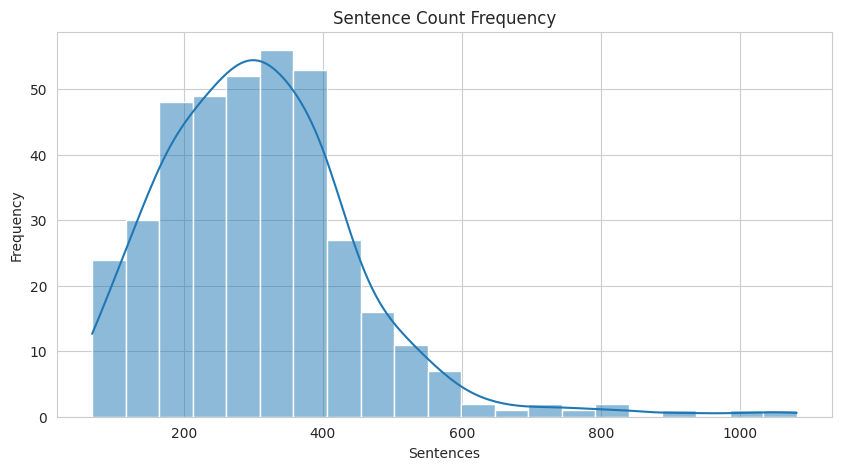

In [ ]:
plt.figure(figsize=[10,5])
sns.histplot(df_stats['sentences'], kde=True)

plt.title('Sentence Count Frequency')
plt.xlabel('Sentences')
plt.ylabel('Frequency')

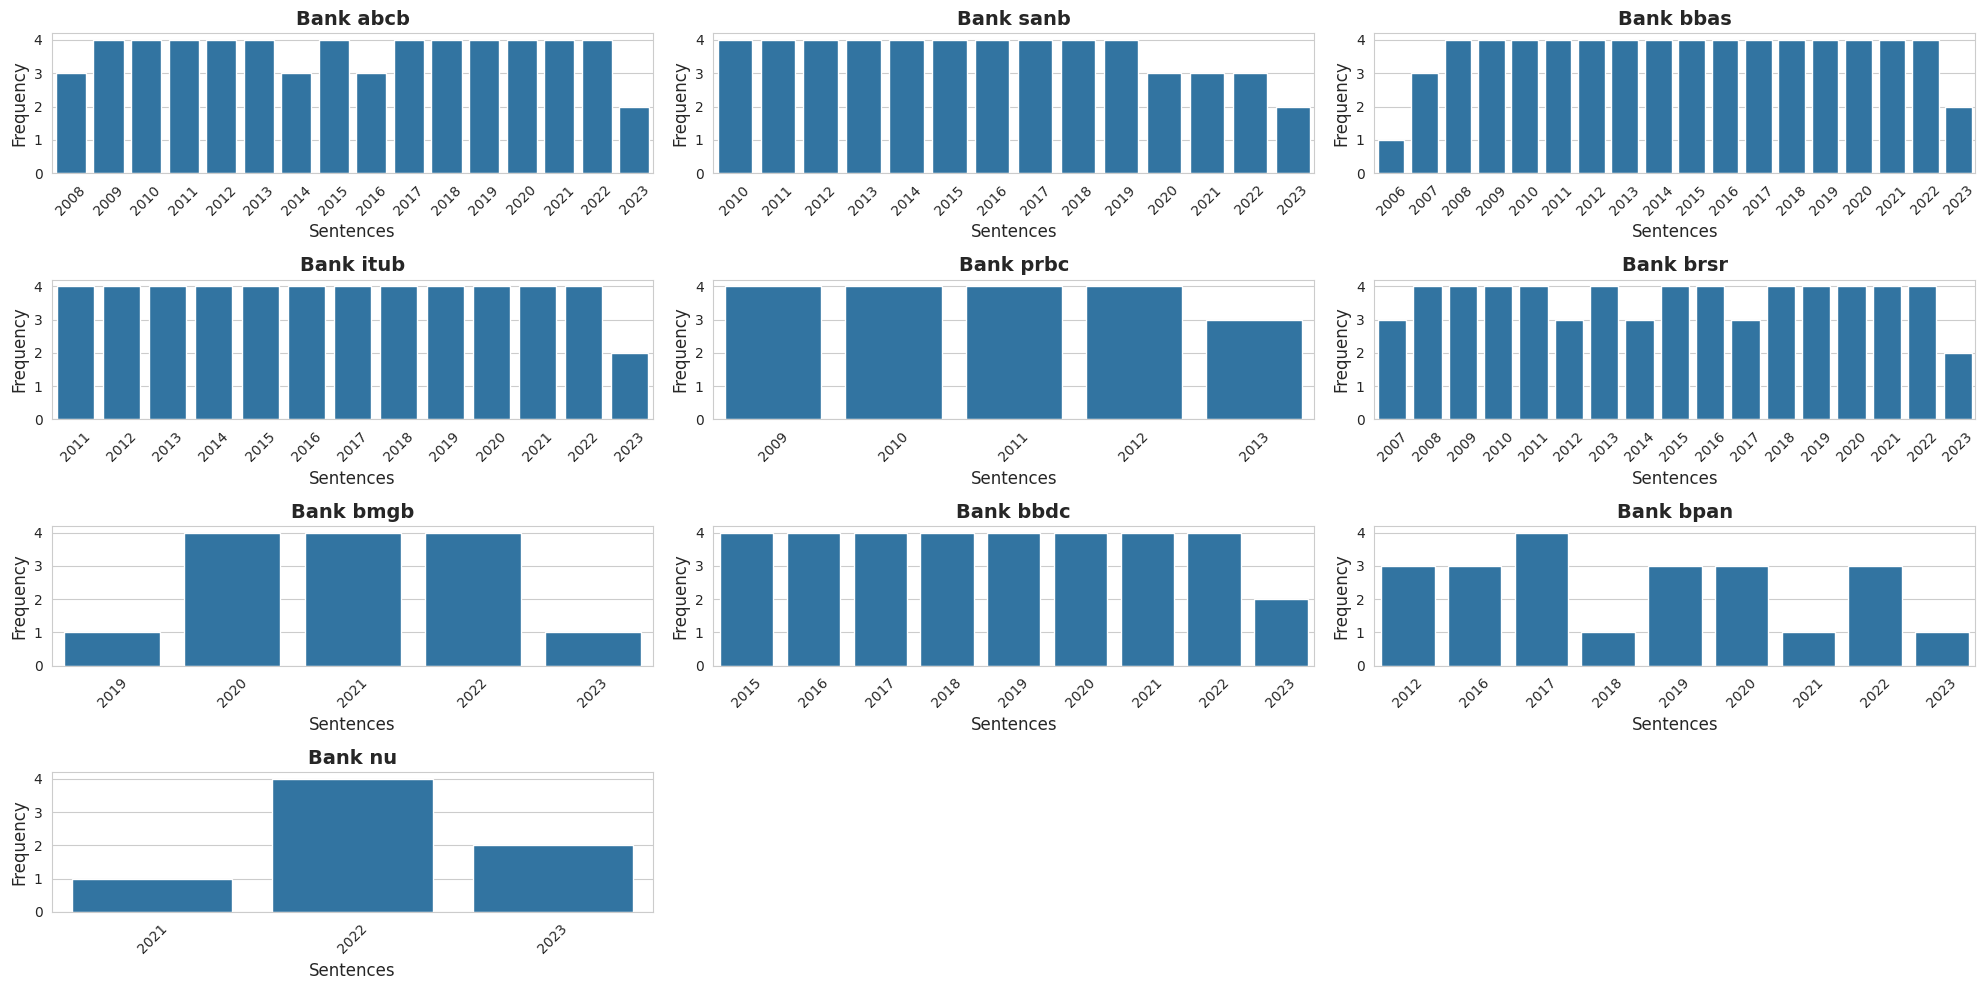

In [ ]:
# Get unique categories
categories = df_stats['bank'].unique()
num_categories = len(categories)

# Define rows and columns
ncols = 3  # Number of columns
nrows = -(-num_categories // ncols)  # Ceiling division to calculate rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes array to easily iterate

# Plot histograms for each category
for i, category in enumerate(categories):
    subset = df_stats[df_stats['bank'] == category].groupby('year')['sentences'].count().reset_index()
    sns.barplot(x='year', y='sentences', data=subset, ax=axes[i])  # Pass `ax=axes[i]`

    axes[i].set_title(f'Bank {category}', fontsize=14, weight='bold')
    axes[i].set_xlabel('Sentences', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if any
for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])



# Adjust layout
plt.tight_layout()
plt.show()

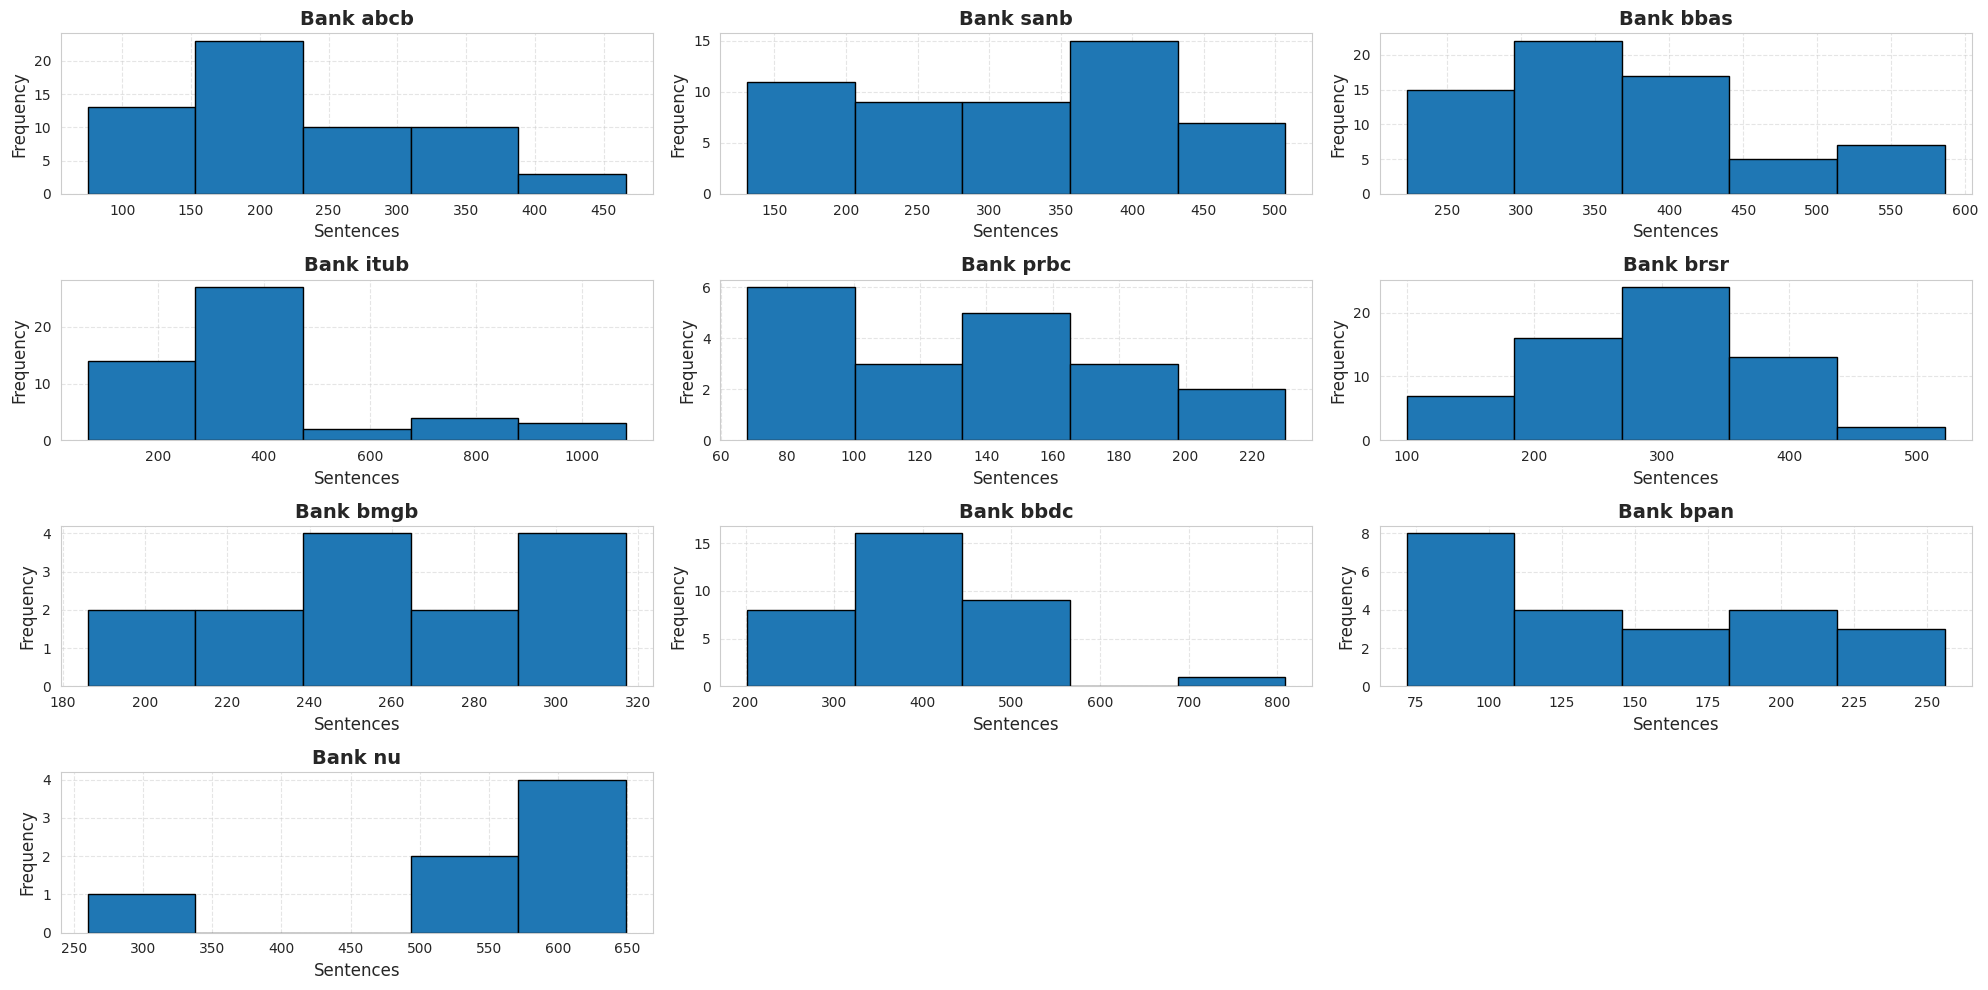

In [ ]:
# Get unique categories
categories = df_stats['bank'].unique()
num_categories = len(categories)

# Define rows and columns
ncols = 3  # Number of columns
nrows = -(-num_categories // ncols)  # Ceiling division to calculate rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes array to easily iterate

# Define color palette
#colors = plt.cm.Paired(range(len(categories)))

# Plot histograms for each category
for i, category in enumerate(categories):
    subset = df_stats[df_stats['bank'] == category]['sentences']
    axes[i].hist(subset, bins=5, edgecolor='black')
    axes[i].set_title(f'Bank {category}', fontsize=14, weight='bold')
    axes[i].set_xlabel('Sentences', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].grid(visible=True, linestyle='--', alpha=0.5)

# Remove empty subplots if any
for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
#plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

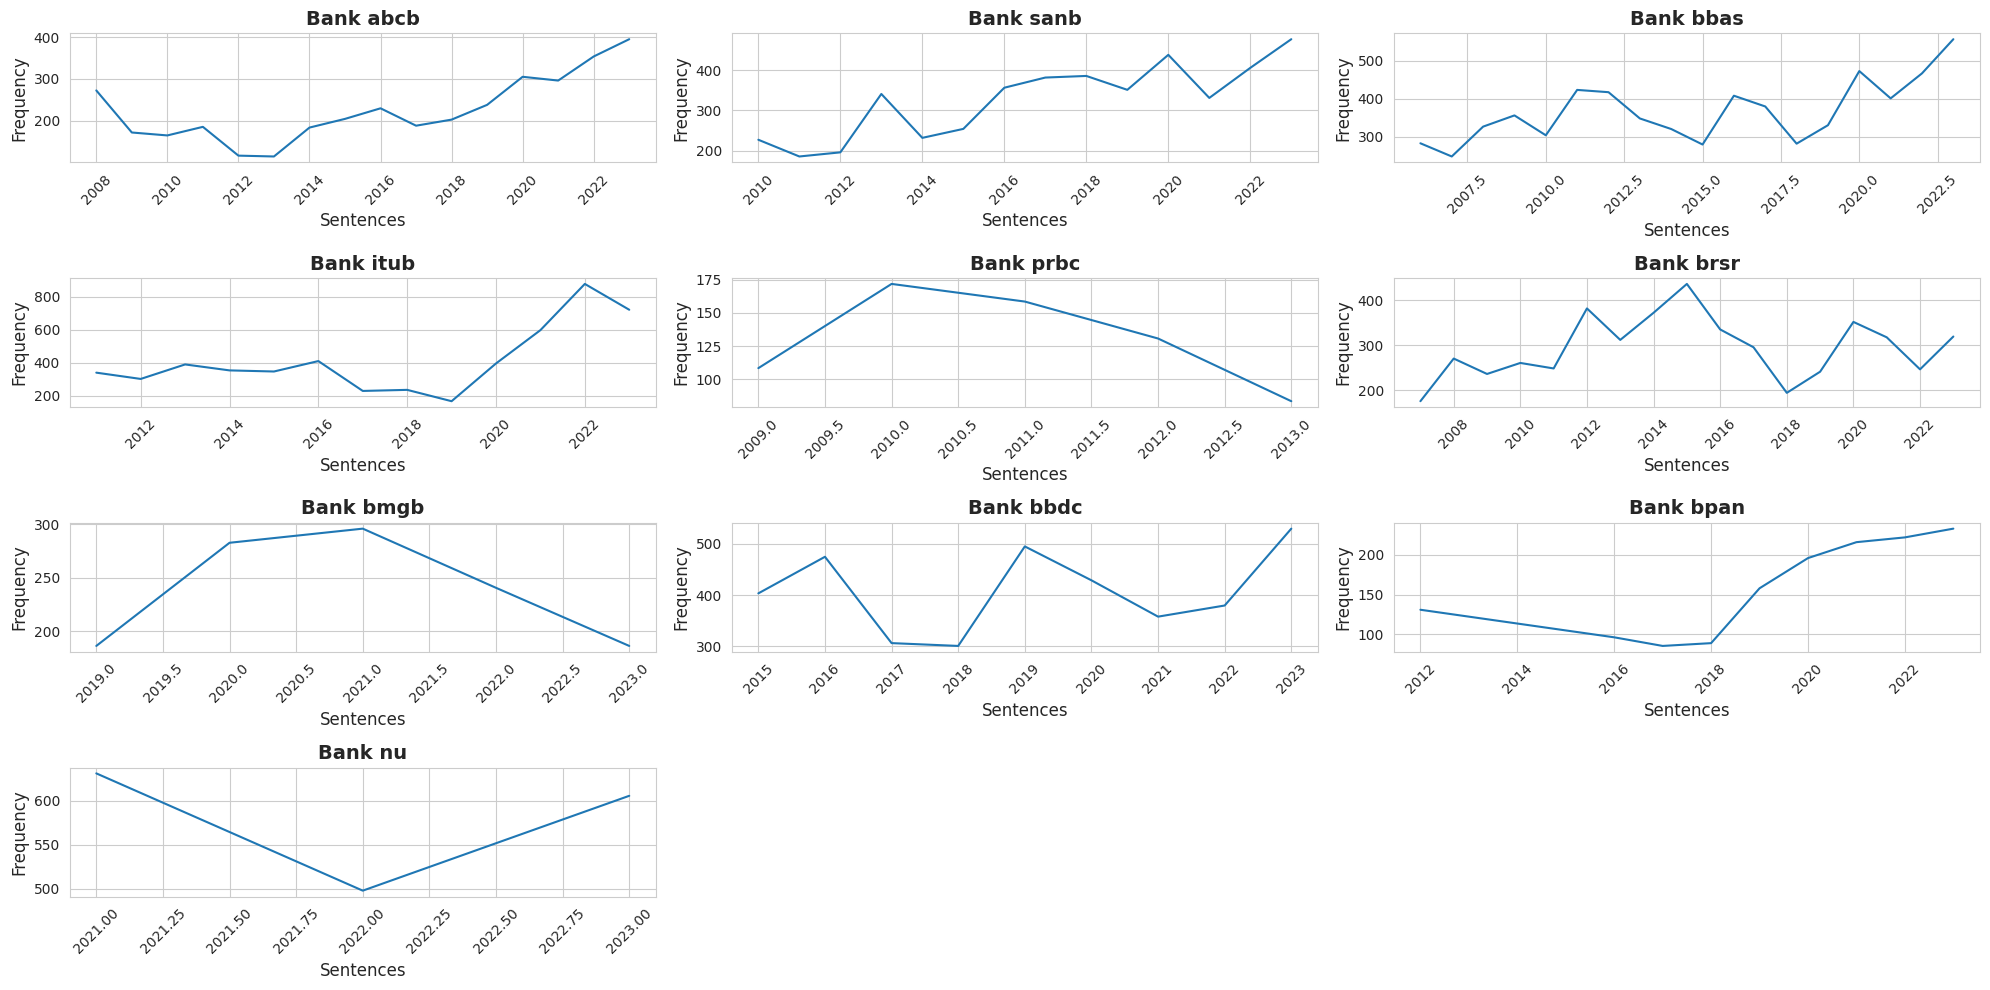

In [ ]:
# Get unique categories
categories = df_stats['bank'].unique()
num_categories = len(categories)

# Define rows and columns
ncols = 3  # Number of columns
nrows = -(-num_categories // ncols)  # Ceiling division to calculate rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes array to easily iterate

# Plot histograms for each category
for i, category in enumerate(categories):
    subset = df_stats[df_stats['bank'] == category].groupby('year')['sentences'].mean().reset_index()
    sns.lineplot(x='year', y='sentences', data=subset, ax=axes[i])  # Pass `ax=axes[i]`

    axes[i].set_title(f'Bank {category}', fontsize=14, weight='bold')
    axes[i].set_xlabel('Sentences', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if any
for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])



# Adjust layout
plt.tight_layout()
plt.show()

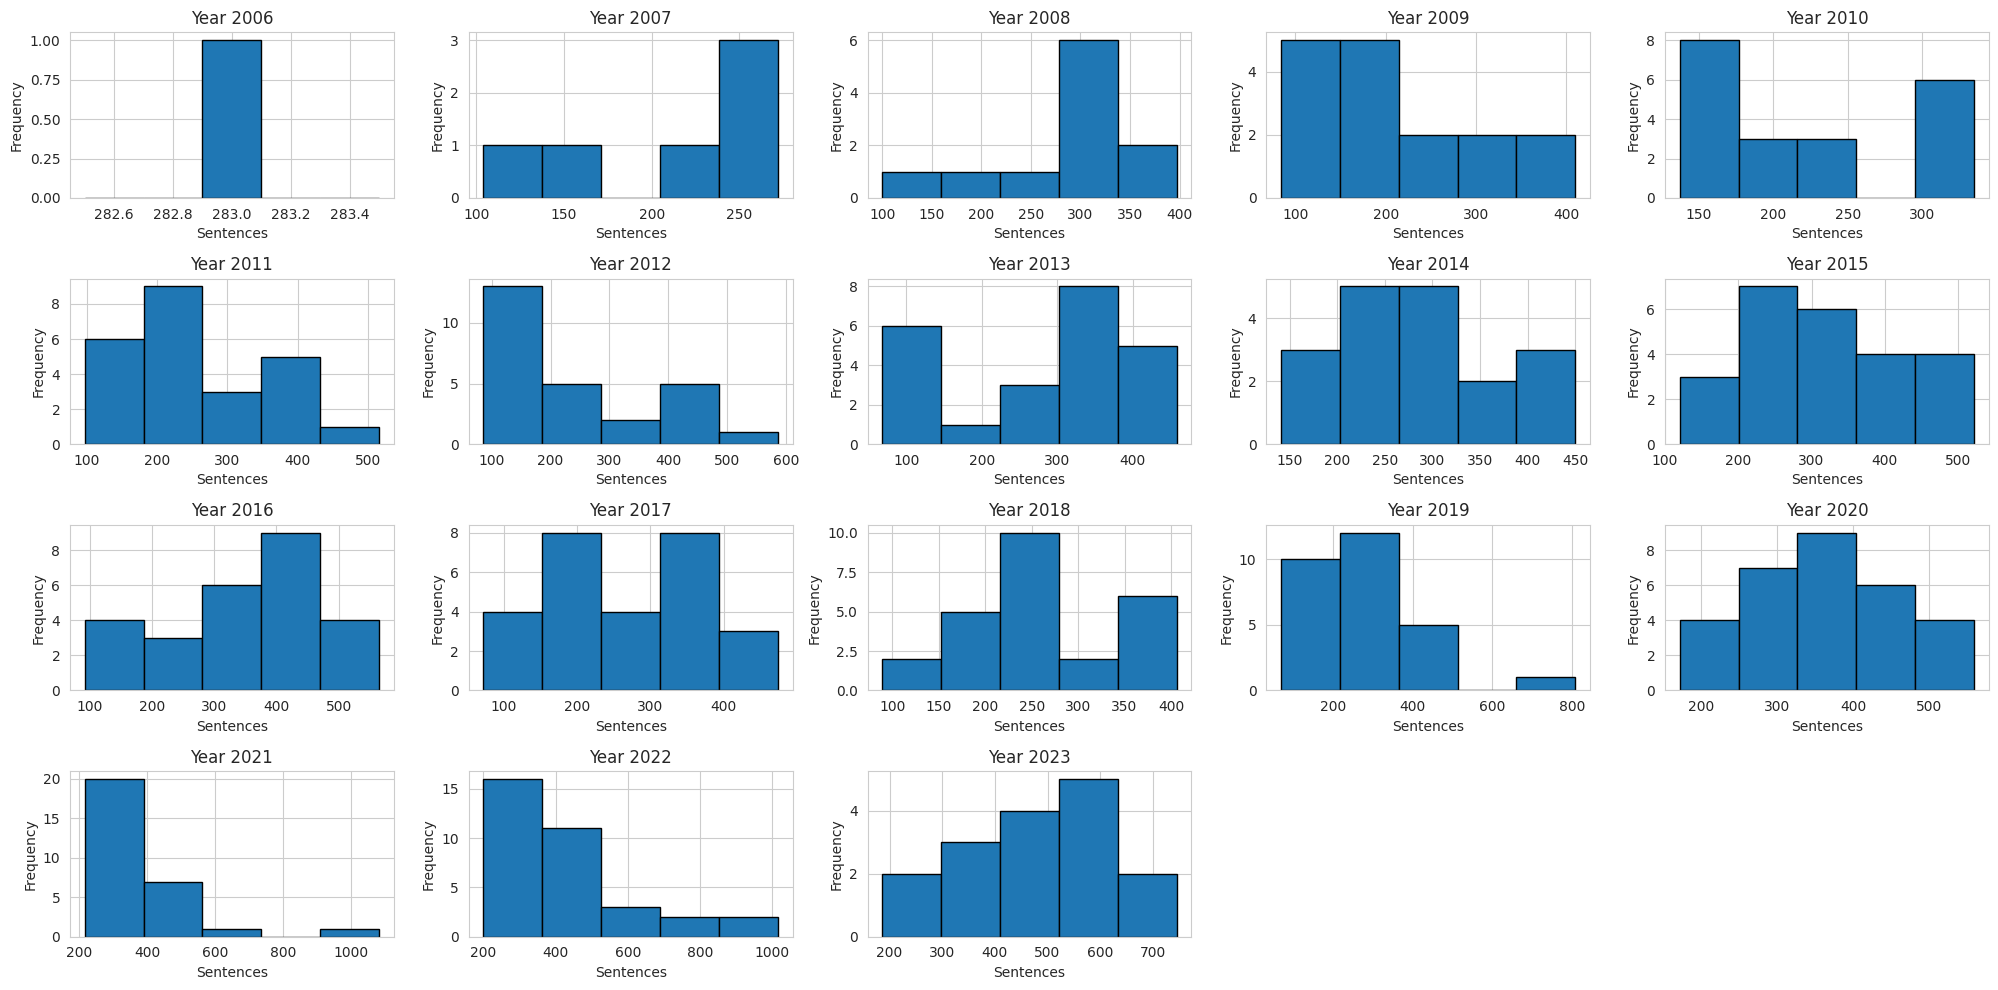

In [ ]:
# Get unique categories
categories = df_stats.sort_values('year')['year'].unique()
num_categories = len(categories)

# Define rows and columns
ncols = 5  # Number of columns
nrows = -(-num_categories // ncols)  # Ceiling division to calculate rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes array to easily iterate

# Plot histograms for each category
for i, category in enumerate(categories):
    subset = df_stats[df_stats['year'] == category]['sentences']
    axes[i].hist(subset, bins=5, edgecolor='black')
    axes[i].set_title(f'Year {category}')
    axes[i].set_xlabel('Sentences')
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if any
for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

# Cotações

In [ ]:
path_cotacoes = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Cotações'
cotacoes_lis = os.listdir(path_cotacoes)
total_path_cotacoes = os.path.join(path_cotacoes, cotacoes_lis[0])
print(total_path_cotacoes)
df_cotacoes_bb = pd.read_csv(total_path_cotacoes, sep=';')

df_cotacoes_bb.columns = df_cotacoes_bb.iloc[0]  # Set the first row as column names
df_cotacoes_bb = df_cotacoes_bb[1:]  # Drop the first row as it is now part of the column names
df_cotacoes_bb.reset_index(drop=True, inplace=True)

df_cotacoes_bb['Abertura'] = df_cotacoes_bb['Abertura'].apply(lambda x: x.replace(',','.'))
#df_cotacoes_bb = df_cotacoes_bb[df_cotacoes_bb['Abertura'][:2] == '01']
#df_cotacoes_bb = df_cotacoes_bb[df_cotacoes_bb['Data'].str.startswith('01')]

# Convert the 'Date' column to pandas datetime
df_cotacoes_bb['Data'] = pd.to_datetime(df_cotacoes_bb['Data'], format='%d/%m/%Y')
# Define the first days of each quarter
first_days_of_quarters = df_cotacoes_bb['Data'].dt.is_quarter_start
# Filter the DataFrame to keep only the first day of each quarter
df_cotacoes_bb = df_cotacoes_bb[first_days_of_quarters]

df_cotacoes_bb['Abertura'] = df_cotacoes_bb['Abertura'].astype(float)

df_cotacoes_bb.head()

/content/drive/MyDrive/Portfolio Projects/Mestrado/Cotações/Histórico de Cotações-20241121 - BB.csv


,Data,Abertura,Máxima,Mínima,Fechado,Média,Variação,Volume,Quantidade de Ações,Negócios
249,2022-07-01,13.54,"13,66","13,44","13,58","13,53","-0,68 %",275857792,8347800,26395
311,2022-04-01,14.01,"14,06","13,75","13,9","13,92","-0,05 %",906718080,26102900,41542
434,2021-10-01,11.14,"11,36","11,09","11,34","11,28","2,24 %",274470016,9342400,19650
498,2021-07-01,12.18,"12,23","11,99","12,02","12,06","-1,05 %",329410176,10320700,22547
560,2021-04-01,11.46,"11,47","11,13","11,15","11,21","-1,64 %",389320992,12932500,41140


In [ ]:
x.head()

,bank,year,trimester,sentences,num_unique_words,tokens
0,abcb,2022,3,232,1723,6638
1,abcb,2010,2,137,989,3232
2,sanb,2015,3,202,1371,4421
3,bbas,2006,4,283,2195,9166
4,itub,2018,4,161,1198,3710


<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

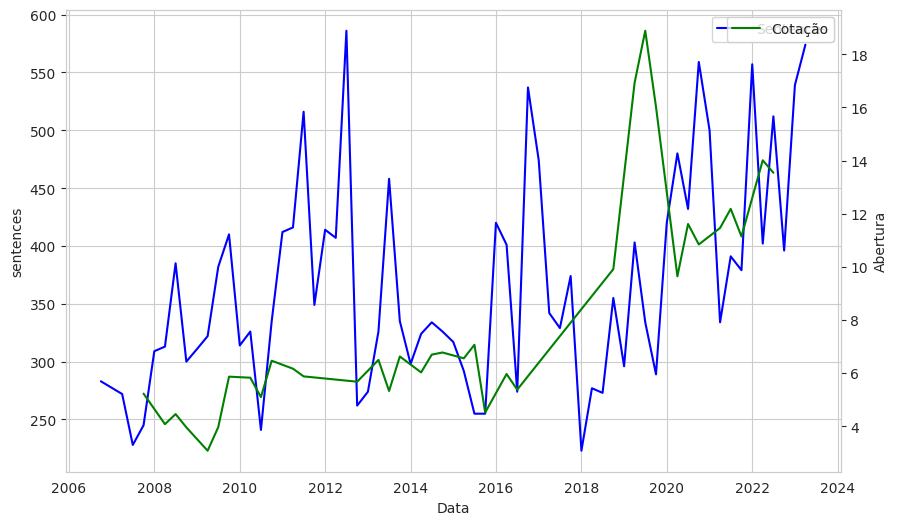

In [ ]:
x = df_stats[df_stats['bank'] == 'bbas'].copy()

plt.figure(figsize=(15, 6))
#x['ano'] = x.astype(int)
x['period'] = x['year'].astype(str) + '-' + x['trimester'].astype(str)

x['Data'] = x.apply(lambda x: '01/01' if x['trimester'] == '1' else ('01/04' if x['trimester'] == '2' else ('01/07' if x['trimester'] == '3' else '01/10')), axis=1) + '/' + x['year'].astype(str)
x['Data'] = pd.to_datetime(x['Data'], format='%d/%m/%Y')

plt.figure(figsize=(15, 6))

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(x = x['Data'], y = x['sentences'], ax = ax1, color='blue', label = 'Sentences')
#sns.lineplot(x = x['period'], y = x['num_unique_words'], label = 'Palavras Únicas')


ax2 = ax1.twinx()
sns.lineplot(x = df_cotacoes_bb['Data'], y = df_cotacoes_bb['Abertura'], ax=ax2, color = 'green', label = 'Cotação')

#ax2.yaxis.set_label_coords(0.1, 0.5)
ax2.grid(False)

plt.xticks(rotation=70)

plt.show()

In [ ]:
x.head()

,bank,year,trimester,sentences,num_unique_words,tokens,period,Data
0,abcb,2022,3,232,1723,6638,2022-3,2022-07-01
1,abcb,2010,2,137,989,3232,2010-2,2010-04-01
2,sanb,2015,3,202,1371,4421,2015-3,2015-07-01
3,bbas,2006,4,283,2195,9166,2006-4,2006-10-01
4,itub,2018,4,161,1198,3710,2018-4,2018-10-01
